<a href="https://colab.research.google.com/github/priyanjalipatel/priyanjalipatel.github.io/blob/master/landsat_unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unet for Landsat images
This notebook adapts the unet implementation from https://github.com/milesial/Pytorch-UNet/

In [ ]:
# To save checkpoints
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Dowload data
!stat split_256x256_0.07_2009.zip || gdown 1lg8nr-6-4tyufZiuXfdqXdoq5MNz5Grl
!mkdir -p data
!unzip -o split_256x256_0.07_2009.zip -d data

Streaming output truncated to the last 5000 lines.
  inflating: data/2009/LT05_L1TP_147037_20090813_20200827_02_T1/270_B6.tif  
  inflating: data/2009/LT05_L1TP_147037_20090813_20200827_02_T1/270_B7.tif  
  inflating: data/2009/LT05_L1TP_147037_20090813_20200827_02_T1/270_mask.png  
  inflating: data/2009/LT05_L1TP_147037_20090813_20200827_02_T1/271_B1.tif  
  inflating: data/2009/LT05_L1TP_147037_20090813_20200827_02_T1/271_B2.tif  
  inflating: data/2009/LT05_L1TP_147037_20090813_20200827_02_T1/271_B3.tif  
  inflating: data/2009/LT05_L1TP_147037_20090813_20200827_02_T1/271_B4.tif  
  inflating: data/2009/LT05_L1TP_147037_20090813_20200827_02_T1/271_B5.tif  
  inflating: data/2009/LT05_L1TP_147037_20090813_20200827_02_T1/271_B6.tif  
  inflating: data/2009/LT05_L1TP_147037_20090813_20200827_02_T1/271_B7.tif  
  inflating: data/2009/LT05_L1TP_147037_20090813_20200827_02_T1/271_mask.png  
  inflating: data/2009/LT05_L1TP_147037_20090813_20200827_02_T1/272_B1.tif  
  inflating: data/200

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch import optim

import cv2

from torch.utils.data import Dataset, DataLoader, random_split
from pathlib import Path
import os

import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt


# Creating the network

In [ ]:
# https://github.com/milesial/Pytorch-UNet/blob/master/unet/unet_parts.py
""" Parts of the U-Net model """

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


In [ ]:
""" Full assembly of the parts to form the complete network """

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)

# Creating the dataset

In [ ]:
class LandsatDataset(Dataset):
    def __init__(self, scenes_dir):
        self.scenes_dir = Path(scenes_dir)
        # p.parent -> folder where patch is
        # p.name.split -> patch idx in folder
        # self.patches = [(p.parent, p.name.split("_", 1)[0]) for p in scenes_dir.rglob("*B4.tif") if cv2.imread(str(p), cv2.IMREAD_UNCHANGED).shape == (256, 256)]
        self.patches = [(p.parent, p.name.split("_", 1)[0]) for p in scenes_dir.rglob("*B4.tif")]

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):
        scene_dir, local_idx = self.patches[idx]
        # print(f"Scene dir: {scene_dir}")
        # print(f"Local index: {local_idx}")


        unordered_tif_files = [f for f in scene_dir.glob(f"{local_idx}_B*.tif") if "(" not in f.name]
        tif_files = sorted(unordered_tif_files, key=lambda x: int(x.stem.rsplit("_", 1)[-1].removeprefix("B")))
        imgs = [np.array(cv2.imread(str(tif_file), cv2.IMREAD_UNCHANGED)) for tif_file in tif_files]
        out_volume = np.stack(imgs, axis=0)

        assert np.max(out_volume) <= 255, "TIFF values higher than expected"
        assert out_volume.shape == (7, 256, 256), f"Error in scene {scene_dir} \n\tError in id {local_idx}"

        # preprocess tiff files
        out_volume = out_volume.astype(np.float64) / 255


        mask_file = next(iter(scene_dir.glob(f"{local_idx}_mask.png")))
        mask = cv2.imread(str(mask_file), cv2.IMREAD_GRAYSCALE)

        # preprocess mask
        mask[mask < 128] = 0
        mask[mask >= 128] = 1


        # pil: width, height
        # numpy: height, width
        # pil to tensor: channels, height, width
        # opencv: height, width, channels

        return {
            "image": torch.Tensor(out_volume.copy()).float().contiguous(),
            "mask": torch.Tensor(mask.copy()).long().contiguous(),
            # "global_idx": idx,
        }



# Dice loss

In [ ]:
def dice_coeff(input, target, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all batches, or for a single mask
    # print(f"Input shape: {input.shape}")
    # print(f"Target shape: {target.shape}")
    # print(f"Input: {input}")
    # print(f"Target: {target}")
    assert input.size() == target.size()
    assert input.dim() == 3 or not reduce_batch_first

    sum_dim = (-1, -2) if input.dim() == 2 or not reduce_batch_first else (-1, -2, -3)

    inter = 2 * (input * target).sum(dim=sum_dim)
    sets_sum = input.sum(dim=sum_dim) + target.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)

    dice = (inter + epsilon) / (sets_sum + epsilon)
    return dice.mean()


def multiclass_dice_coeff(input, target, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all classes
    return dice_coeff(input.flatten(0, 1), target.flatten(0, 1), reduce_batch_first, epsilon)


def dice_loss(input, target, multiclass: bool = False):
    # Dice loss (objective to minimize) between 0 and 1
    fn = multiclass_dice_coeff if multiclass else dice_coeff
    return 1 - fn(input, target, reduce_batch_first=True)

# Evaluate function

In [ ]:
@torch.inference_mode()
def evaluate(net, dataloader, device, amp):
    net.eval()
    num_val_batches = len(dataloader)
    dice_score = 0


    # iterate over the validation set
    with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
        for batch in tqdm(dataloader, total=num_val_batches, desc='Validation round', unit='batch', leave=False):
            image, mask_true = batch['image'], batch['mask']
            # image, mask_true, global_idx = batch['image'], batch['mask'], batch["global_idx"]
            # print(f"Current example: {global_idx}")


            # move images and labels to correct device and type
            image = image.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
            mask_true = mask_true.to(device=device, dtype=torch.long)

            # predict the mask
            mask_pred = net(image)
            mask_pred = torch.squeeze(mask_pred, dim=1)

            if net.n_classes == 1:
                assert mask_true.min() >= 0 and mask_true.max() <= 1, 'True mask indices should be in [0, 1]'
                mask_pred = (F.sigmoid(mask_pred) > 0.5).float()
                # compute the Dice score
                dice_score += dice_coeff(mask_pred, mask_true, reduce_batch_first=False)
            else:
                assert mask_true.min() >= 0 and mask_true.max() < net.n_classes, 'True mask indices should be in [0, n_classes['
                # convert to one-hot format
                mask_true = F.one_hot(mask_true, net.n_classes).permute(0, 3, 1, 2).float()
                mask_pred = F.one_hot(mask_pred.argmax(dim=1), net.n_classes).permute(0, 3, 1, 2).float()
                # compute the Dice score, ignoring background
                dice_score += multiclass_dice_coeff(mask_pred[:, 1:], mask_true[:, 1:], reduce_batch_first=False)

    net.train()
    return dice_score / max(num_val_batches, 1)

# Config

In [ ]:
#  Data
data_path = Path("/content/data/2009")
val_percent=0.15
batch_size=32
n_channels=7
n_classes=1

#  Training
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
learning_rate=0.01
weight_decay=0
momentum=0
amp=False
epochs=30
gradient_clipping=1.0

#  Checkpoints
save_checkpoint=True
dir_checkpoint=Path("/content/drive/MyDrive/Omdena/Ladakh/checkpoints")

# Dataset
dataset = LandsatDataset(data_path)

n_val = int(len(dataset) * val_percent)
n_train = len(dataset) - n_val
train_set, val_set = random_split(dataset, [n_train, n_val], generator=torch.Generator().manual_seed(0))

loader_args = dict(batch_size=batch_size, num_workers=os.cpu_count(), pin_memory=True)
train_loader = DataLoader(train_set, shuffle=True, **loader_args)
val_loader = DataLoader(val_set, shuffle=False, drop_last=True, **loader_args)


print(f'''
    Data path:       {data_path}
    Epochs:          {epochs}
    Batch size:      {batch_size}
    Learning rate:   {learning_rate}
    Training size:   {n_train}
    Validation size: {n_val}
    Checkpoints:     {save_checkpoint}
    Device:          {device.type}
    Mixed Precision: {amp}
''')

# Change here to adapt to your data
# n_channels=3 for RGB images
# n_classes is the number of probabilities you want to get per pixel
model = UNet(n_channels=n_channels, n_classes=n_classes, bilinear=False)
model = model.to(device=device, memory_format=torch.channels_last)

print(f'Network:\n'
                f'\t{model.n_channels} input channels\n'
                f'\t{model.n_classes} output channels (classes)\n'
                f'\t{"Bilinear" if model.bilinear else "Transposed conv"} upscaling')


optimizer = optim.RMSprop(model.parameters(),
                            lr=learning_rate, weight_decay=weight_decay, momentum=momentum, foreach=True)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5)  # goal: maximize Dice score
grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
criterion = nn.CrossEntropyLoss() if model.n_classes > 1 else nn.BCEWithLogitsLoss()


    Data path:       /content/data/2009
    Epochs:          30
    Batch size:      32
    Learning rate:   0.01
    Training size:   1920
    Validation size: 338
    Checkpoints:     True
    Device:          cpu
    Mixed Precision: False

Network:
	7 input channels
	1 output channels (classes)
	Transposed conv upscaling


# Training

In [ ]:
# Training
global_step = 0
for epoch in range(1, epochs + 1):
    model.train()
    epoch_loss = 0
    with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
        for batch in train_loader:
            images, true_masks = batch['image'], batch['mask']

            assert images.shape[1] == model.n_channels, \
                f'Network has been defined with {model.n_channels} input channels, ' \
                f'but loaded images have {images.shape[1]} channels. Please check that ' \
                'the images are loaded correctly.'

            images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
            true_masks = true_masks.to(device=device, dtype=torch.long)

            with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
                masks_pred = model(images)
                if model.n_classes == 1:
                    loss = criterion(masks_pred.squeeze(1), true_masks.float())
                    loss += dice_loss(F.sigmoid(masks_pred.squeeze(1)), true_masks.float(), multiclass=False)
                else:
                    loss = criterion(masks_pred, true_masks)
                    loss += dice_loss(
                        F.softmax(masks_pred, dim=1).float(),
                        F.one_hot(true_masks, model.n_classes).permute(0, 3, 1, 2).float(),
                        multiclass=True
                    )

            optimizer.zero_grad(set_to_none=True)
            grad_scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
            grad_scaler.step(optimizer)
            grad_scaler.update()

            pbar.update(images.shape[0])
            global_step += 1
            epoch_loss += loss.item()
            pbar.set_postfix(**{'loss (batch)': loss.item()})

            # Evaluation round
            division_step = (n_train // (5 * batch_size))
            if division_step > 0:
                if global_step % division_step == 0:
                    val_score = evaluate(model, val_loader, device, amp)
                    scheduler.step(val_score)

                    print('Validation Dice score: {}'.format(val_score))

    if save_checkpoint:
        Path(dir_checkpoint).mkdir(parents=True, exist_ok=True)
        state_dict = model.state_dict()
        torch.save(state_dict, str(dir_checkpoint / 'checkpoint_epoch{}.pth'.format(epoch)))
        print(f'Checkpoint {epoch} saved!')

# Results

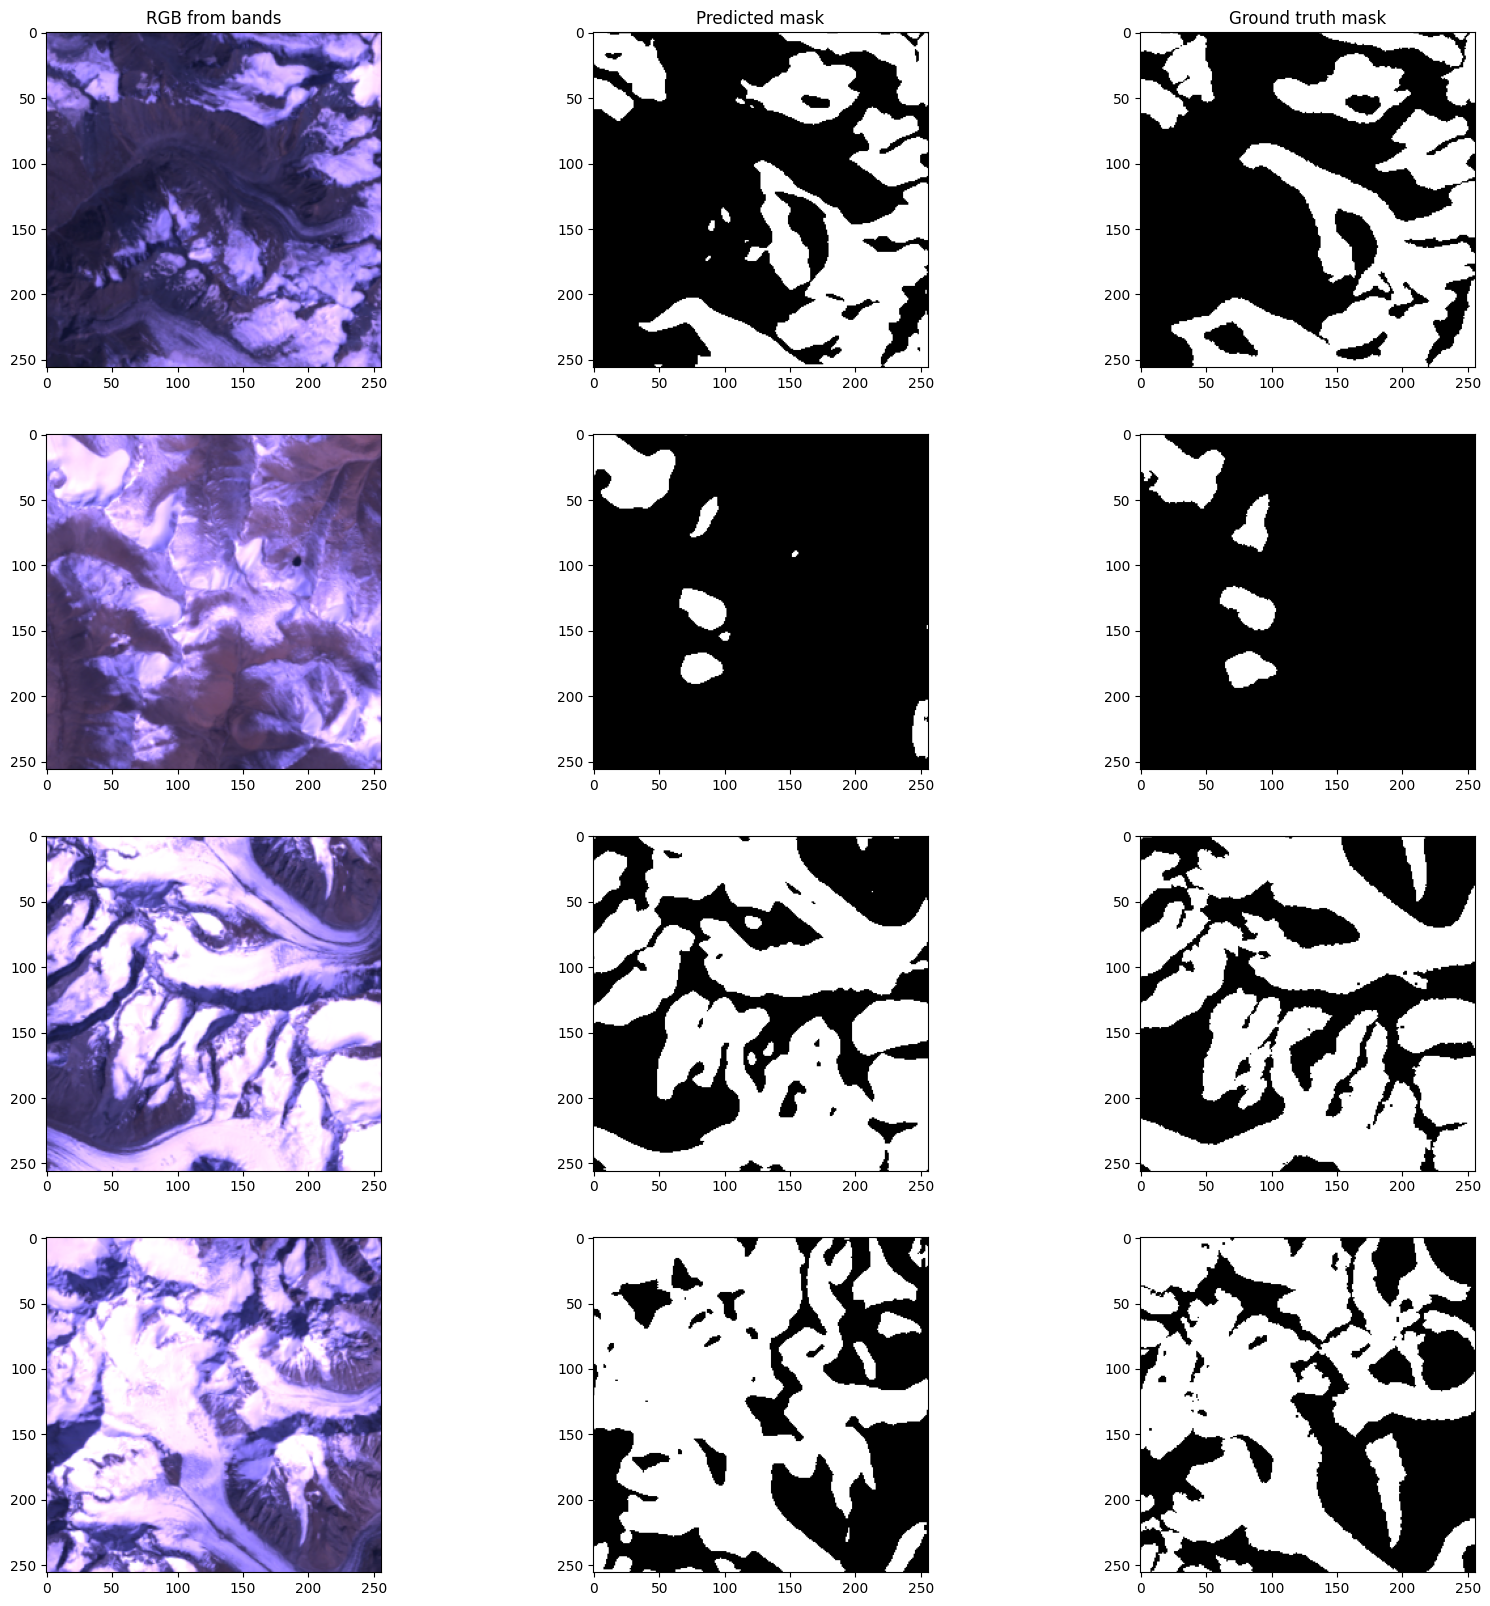

In [ ]:
latest_checkpoint = sorted(dir_checkpoint.iterdir(), key=os.path.getmtime)[-1]
model.load_state_dict(torch.load(latest_checkpoint, map_location=device))
model.eval()

n_rows = 4
fig, axs = plt.subplots(n_rows, 3, figsize=(20, 20))
axs[0, 0].set_title("RGB from bands")
axs[0, 1].set_title("Predicted mask")
axs[0, 2].set_title("Ground truth mask")

for i in range(n_rows):
    image, mask = val_set[i].values()

    img = np.array(image)[0:3,...].transpose(1, 2, 0)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    mask_pred = model(torch.unsqueeze(image, dim=0))
    mask_pred = (F.sigmoid(mask_pred) > 0.5).float()

    axs[i, 0].imshow(img)
    axs[i, 1].imshow(torch.squeeze(mask_pred.detach()), cmap="gray")
    axs[i, 2].imshow(mask, cmap="gray")


In [ ]:
print(model)

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(7, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 

In [ ]:
# data_path = Path("/content/drive/MyDrive/Omdena/Ladakh/split/0.07-256x256/2009")
# dataset = LandsatDataset(data_path)

# train_set, val_set = random_split(dataset, [n_train, n_val], generator=torch.Generator().manual_seed(0))

# loader_args = dict(batch_size=10, num_workers=os.cpu_count(), pin_memory=True)
# val_loader = DataLoader(val_set, shuffle=False, drop_last=True, **loader_args)

# evaluate(model, val_loader, device, amp)


